This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [1]:
import argparse
import os
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from notebook_init_utils import bandicoot_check, init_notebook
from skimage import io

root_dir, in_notebook = init_notebook()
image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

## parse args and set paths

If as a notebook, then it will run the hardcoded paths.
However, if this is run as a script, the paths are set by the parsed arguments.

In [2]:
if not in_notebook:
    args_dict = parse_args()
    patient = args_dict["patient"]
    well_fov = args_dict["well_fov"]
    clip_limit = args_dict["clip_limit"]
    twoD_method = args_dict["twoD_method"]
    overwrite = args_dict.get("overwrite", False)
    check_for_missing_args(
        patient=patient,
        well_fov=well_fov,
        clip_limit=clip_limit,
        twoD_method=twoD_method,
    )
else:
    print("Running in a notebook")
    patient = "NF0040_T1"
    well_fov = "E7-1"
    clip_limit = 0.01
    twoD_method = "middle_n"
    overwrite = True

if twoD_method == "zmax":
    input_dir = pathlib.Path(
        f"{image_base_dir}/data/{patient}/2D_analysis/1a.zmax_proj_illum_correction/{well_fov}"
    ).resolve(strict=True)
elif twoD_method == "middle":
    input_dir = pathlib.Path(
        f"{image_base_dir}/data/{patient}/2D_analysis/1b.middle_slice_illum_correction/{well_fov}"
    ).resolve(strict=True)
elif twoD_method == "middle_n":
    input_dir = pathlib.Path(
        f"{image_base_dir}/data/{patient}/2D_analysis/1c.middle_n_slice_max_proj_illum_correction/{well_fov}"
    ).resolve(strict=True)
else:
    raise ValueError(f"Unknown twoD_method: {twoD_method}")

labels_path = input_dir / f"{well_fov}_nuclei_masks.tiff"


mask_path = input_dir

Running in a notebook


## Set up images, paths and functions

In [3]:
if overwrite or not labels_path.exists():
    image_extensions = {".tif", ".tiff"}
    files = sorted(input_dir.glob("*"))
    files = [str(x) for x in files if x.suffix in image_extensions]
    # get the nuclei image
    for f in files:
        if "405" in f:
            nuclei = io.imread(f)
    nuclei = np.array(nuclei)
    nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)

    use_GPU = torch.cuda.is_available()
    # Load the model
    model_name = "nuclei"
    model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

    labels, details, _ = model.eval(nuclei, diameter=75, channels=[0, 0])

    # save the labels
    tifffile.imwrite(labels_path, labels.astype(np.uint16))

model_type argument is not used in v4.0.1+. Ignoring this argument...
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+


<Figure size 1000x500 with 0 Axes>

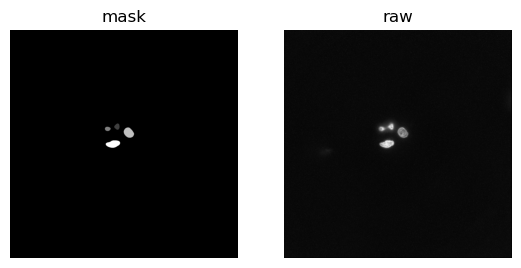

In [4]:
if in_notebook:
    plot = plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(labels, cmap="gray")
    plt.title("mask")
    plt.axis("off")

    plt.subplot(132)
    plt.imshow(nuclei, cmap="gray")
    plt.title("raw")
    plt.axis("off")